A script to show how to get started with segmenting superpixels in PETCT images. Here we show both 2d, 3d, single channel and multichannel analyses

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import h5py

from skimage.util.montage import montage2d
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Loading and Displaying PET and CT

Here we load the PET and CT data for all patients and show the projection images for CT and the MIP view for the PET data

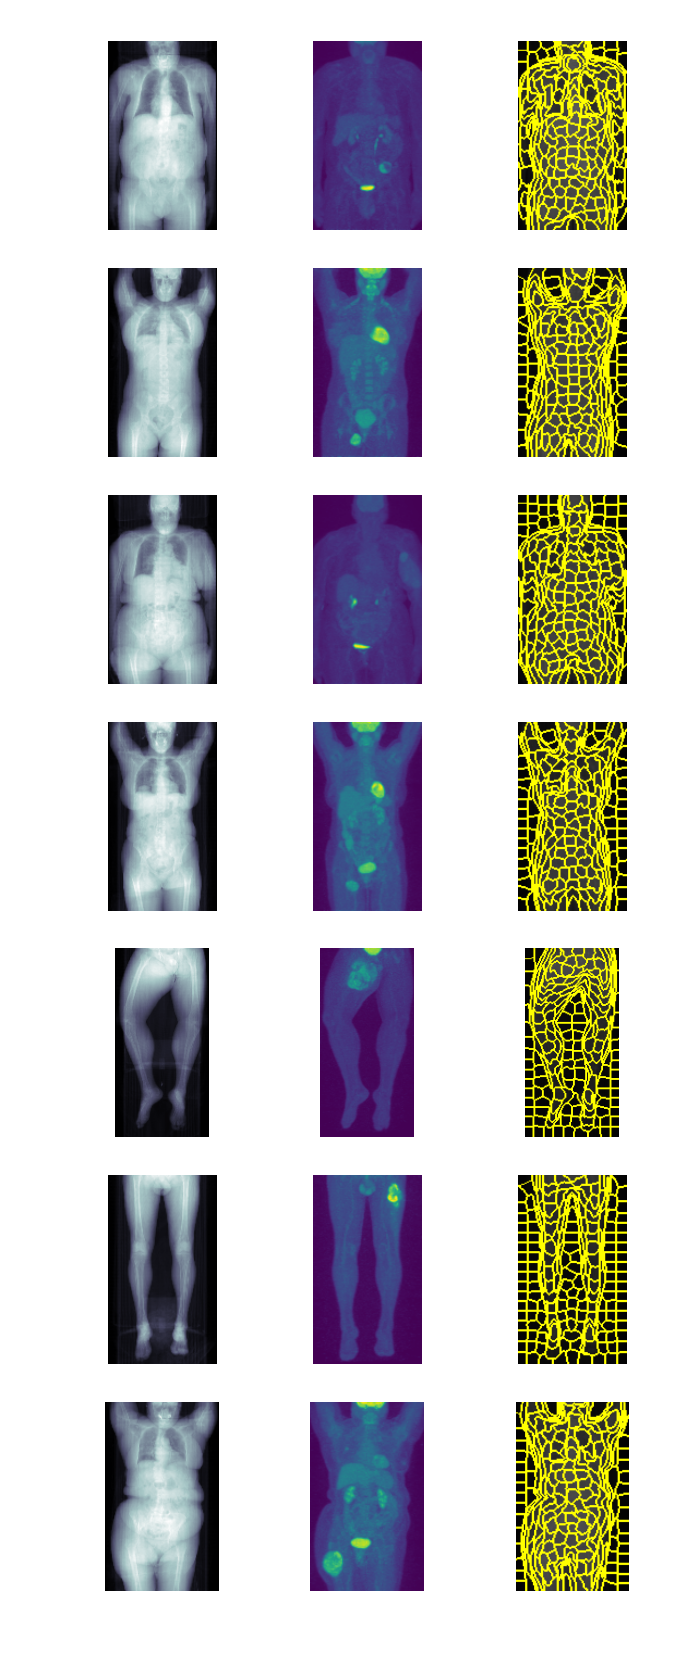

In [3]:
slic_n_segments = 200
slic_compactness = 0.02
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    ct_images = p_data['ct_data'].items()
    pet_images = p_data['pet_data'].values()
    
    fig, sb_mat = plt.subplots(7, 3, figsize=(3, 8), dpi=250) # sb_mat is a array of 3x4 
    (ax1s, ax2s, ax3s) = sb_mat.T # transpose the array
    for c_ax1, c_ax2, c_ax3, (p_id, ct_img), pet_img in zip(ax1s, ax2s, ax3s, ct_images, pet_images):
        ct_image = np.mean(ct_img, 1)[::-1]
        c_ax1.imshow(ct_image, cmap = 'bone')
        c_ax1.axis('off')
        
        pet_image = np.sqrt(np.max(pet_img,1).squeeze()[::-1,:])
        c_ax2.imshow(pet_image, cmap = 'viridis')
        c_ax2.axis('off')
        
        n_ct_img = (ct_image + 1024).clip(0, 2048) / 2048
        ct_segs = slic(n_ct_img, n_segments = slic_n_segments, compactness = slic_compactness, sigma=1)
        
        c_ax3.imshow(mark_boundaries(n_ct_img, ct_segs))
        c_ax3.axis('off')

In [4]:
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    id_list = list(p_data['ct_data'].keys())
    print(list(p_data.keys()))
    print(id_list[0])
    print(type(p_data['ct_data']))
    cts = p_data['ct_data']
    for ct in cts:
        print(ct)
    pets = p_data['pet_data']
    print('---')
    for pet in pets:
        print(pet)
    
    pet_images = p_data['pet_data']

print(type(ct_images))
print(ct_images)

['ct_data', 'label_data', 'pet_data']
STS_002
<class 'h5py._hl.group.Group'>
STS_002
STS_003
STS_005
STS_012
STS_021
STS_023
STS_031
---
STS_002
STS_003
STS_005
STS_012
STS_021
STS_023
STS_031
<class 'h5py._hl.base.ItemsViewHDF5'>
ItemsViewHDF5(<Closed HDF5 group>)


['ct_data', 'label_data', 'pet_data']
STS_002


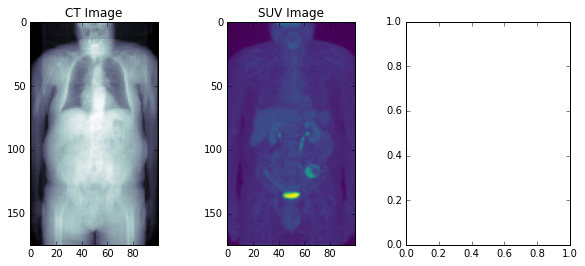

In [5]:
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    id_list = list(p_data['ct_data'].keys())
    print(list(p_data.keys()))
    print(id_list[0])
    ct_image = p_data['ct_data'][id_list[0]].value
    pet_image = p_data['pet_data'][id_list[0]].value
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4))
ct_proj = np.mean(ct_image, 1)[::-1]
suv_max = np.sqrt(np.max(pet_image, 1)[::-1])
ax1.imshow(ct_proj, cmap = 'bone')
ax1.set_title('CT Image')
ax2.imshow(suv_max, cmap = 'viridis')
ax2.set_title('SUV Image')

# Make a Superpixel Segmentation of the images
We make basic superpixels for the CT image here. The primary parameters we adjust are the 

 - **n_segments** the number of different segments to make (approximately)
 - **compactness** the weight of spatial dimensions versus image intensity (low values are more irregularly shaped)

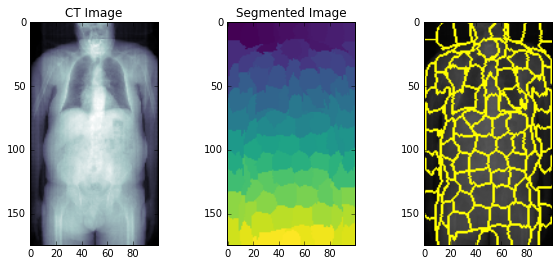

In [6]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4))
n_ct_img = (ct_proj + 1024).clip(0, 2048) / 2048
ct_segs = slic(n_ct_img, n_segments = 100, compactness = 0.05)
ax1.imshow(ct_proj, cmap = 'bone')
ax1.set_title('CT Image')
ax2.imshow(ct_segs, cmap = plt.cm.viridis)
ax2.set_title('Segmented Image')
ax3.imshow(mark_boundaries(n_ct_img, ct_segs))

# Using PET Signal
Here we use PET Signal as well as CT for making segmentations

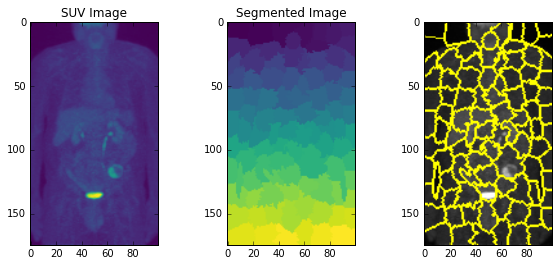

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4))
n_suv_img = (suv_max).clip(0, 5) / 5.0
pet_segs = slic(n_suv_img, n_segments = 100, compactness = 0.05)
ax1.imshow(suv_max, cmap = 'viridis')
ax1.set_title('SUV Image')
ax2.imshow(pet_segs, cmap = plt.cm.viridis)
ax2.set_title('Segmented Image')
ax3.imshow(mark_boundaries(n_suv_img, pet_segs))

# Combined PET/CT Super-pixels
Here we use image data from both PET and CT

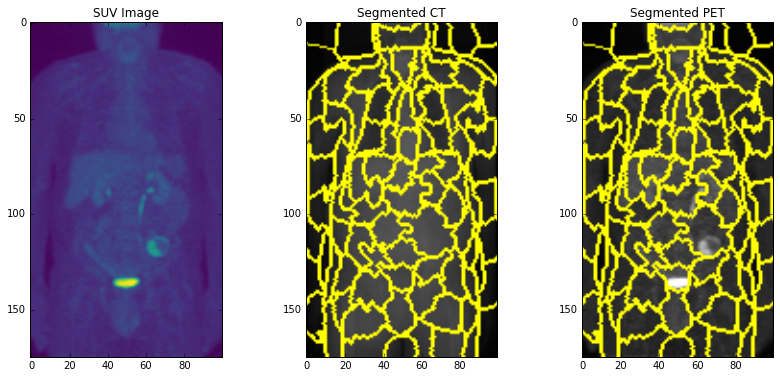

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 6))
petct_segs = slic(np.stack([n_ct_img, n_suv_img], -1), n_segments = 100, compactness = 0.05)

ax1.imshow(suv_max, cmap = 'viridis')
ax1.set_title('SUV Image')
ax2.imshow(mark_boundaries(n_ct_img, petct_segs))
ax2.set_title('Segmented CT')
ax3.imshow(mark_boundaries(n_suv_img, petct_segs))
ax3.set_title('Segmented PET')

# Full 3D Superpixels
Here we make full 3D superpixels for PETCT and show a simple rendering of them

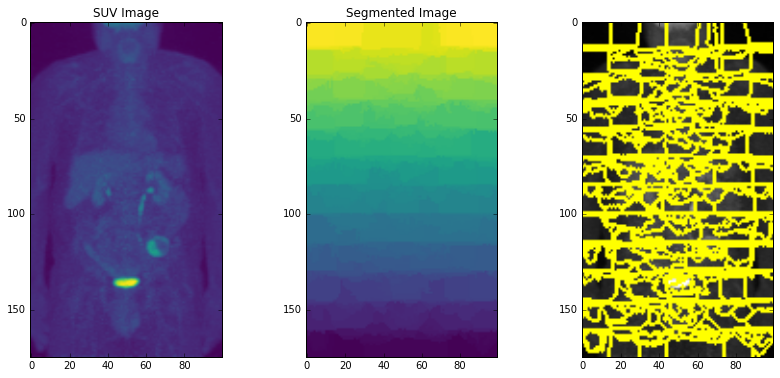

In [9]:
petct_segs = slic(np.stack([np.stack([(ct_slice + 1024).clip(0, 2048) / 2048, 
                            np.sqrt((suv_slice).clip(0, 5) / 5.0)
                           ], -1) for ct_slice, suv_slice in zip(ct_image, pet_image)], 0), 
                  n_segments = 500, 
                  compactness = 0.1,
                  multichannel = True)

petct_max_segs = np.max(petct_segs,1)[::-1]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 6))
ax1.imshow(suv_max, cmap = 'viridis')
ax1.set_title('SUV Image')
ax2.imshow(petct_max_segs, cmap = plt.cm.viridis)
ax2.set_title('Segmented Image')
ax3.imshow(mark_boundaries(n_suv_img, petct_max_segs))

Kept 5 of 444


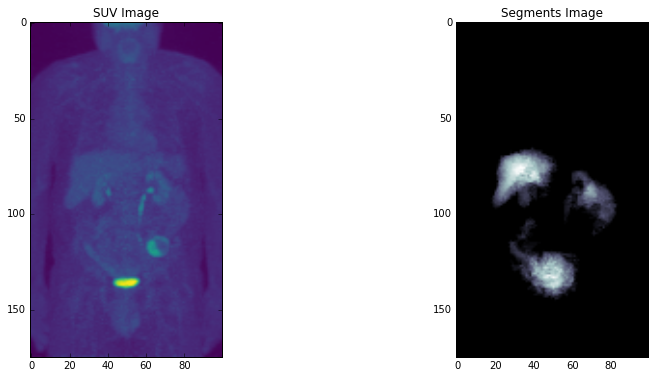

In [15]:
bright_segs = np.zeros_like(petct_segs)
kept_comps = 0
for i in np.unique(petct_segs):
    if pet_image[petct_segs == i].mean()>1.5:
        bright_segs[petct_segs == i] = 1
        kept_comps+=1
print('Kept', kept_comps,'of', len(np.unique(petct_segs)))
bright_sum_segs = np.sum(bright_segs,1)[::-1]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
ax1.imshow(suv_max, cmap = 'viridis')
ax1.set_title('SUV Image')
ax2.imshow(bright_sum_segs, cmap = plt.cm.bone)
ax2.set_title('Segments Image')

In [11]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
def show_3d_mesh(image, threshold):
    p = image[::-1].swapaxes(1,2)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([.1, 1, .1])
    mesh.set_edgecolor([1, 0, 0])
    
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    ax.view_init(80, 5)
    return fig

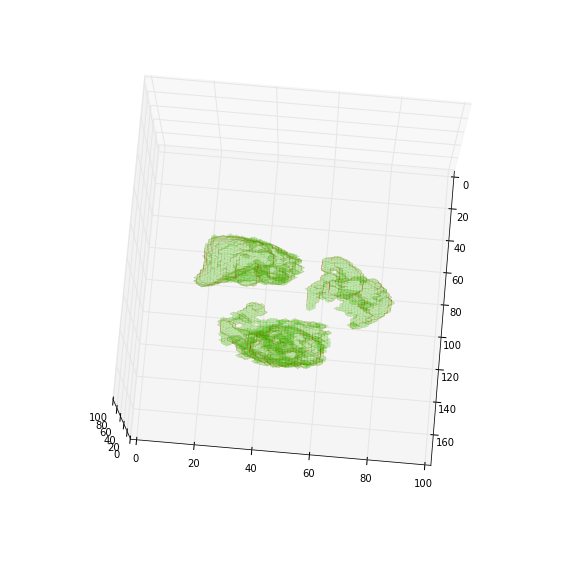

In [12]:
_ = show_3d_mesh(bright_segs, 0)

In [13]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
def show_pet_3d(image, pet_signal, threshold):
    p = image[::-1].swapaxes(1,2)

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(121, projection='3d')
    
    verts, faces = measure.marching_cubes(p, 0)
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([.1, 1, .1])
    mesh.set_edgecolor([1, 0, 0])
    
    ax1.add_collection3d(mesh)

    ax1.set_xlim(0, p.shape[0])
    ax1.set_ylim(0, p.shape[1])
    ax1.set_zlim(0, p.shape[2])
    
    ax1.view_init(80, 5)
    
    ax2 = fig.add_subplot(122, projection='3d')
    p_pet = pet_signal[::-1].swapaxes(1,2)
    
    verts, faces = measure.marching_cubes(p_pet, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([1, 0, .1])
    mesh.set_edgecolor([.1, 0, 1.0])
    
    ax2.add_collection3d(mesh)

    ax2.set_xlim(0, p.shape[0])
    ax2.set_ylim(0, p.shape[1])
    ax2.set_zlim(0, p.shape[2])
    ax2.view_init(80, 5)
    return fig

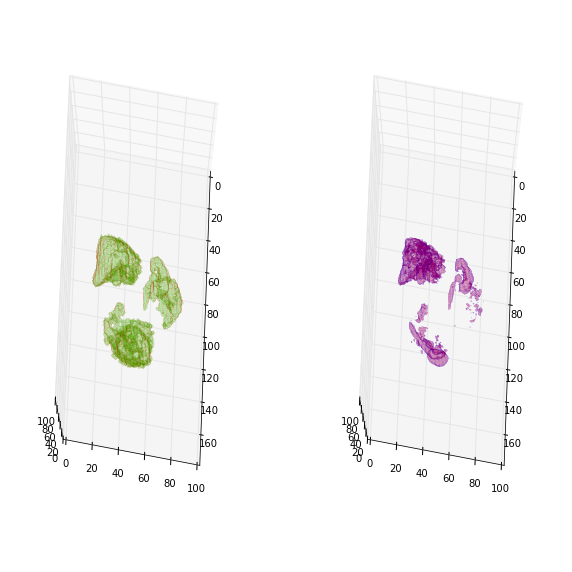

In [14]:
bright_seg_pet = pet_image.copy()
bright_seg_pet[bright_segs==0] = 0
_ = show_pet_3d(bright_segs, bright_seg_pet, 1.5)